# Text to MySQL Agent


## Download the database

The Northwind database is a sample database that was originally created by Microsoft and used as the basis for their tutorials in a variety of database products for decades. The Northwind database contains the sales data for a fictitious company called “Northwind Traders,” which imports and exports specialty foods from around the world. The Northwind database is an excellent tutorial schema for a small-business ERP, with customers, orders, inventory, purchasing, suppliers, shipping, employees, and single-entry accounting. The Northwind database has since been ported to a variety of non-Microsoft databases, including PostgreSQL.

The Northwind dataset includes sample data for the following.

- Suppliers: Suppliers and vendors of Northwind
- Customers: Customers who buy products from Northwind
- Employees: Employee details of Northwind traders
- Products: Product information
- Shippers: The details of the shippers who ship the products from the traders to the end-customers
- Orders and Order_Details: Sales Order transactions taking place between the customers & the company

The Northwind sample database includes 14 tables and the table relationships are showcased in the following entity relationship diagram.

![image.png](https://docs.yugabyte.com/images/sample-data/northwind/northwind-er-diagram.png)

In [ ]:
## Download the database from KaggleHub


import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravmodi/northwinddb")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\aruns\.cache\kagglehub\datasets\gauravmodi\northwinddb\versions\1


In [ ]:
## Move the database to the correct location
import shutil
import os

# Define the source and destination paths
source_path = os.path.join(path, "northwind.db")
destination_path = os.path.join(os.getcwd(), "northwind.db")

# Create the destination directory if it doesn't exist
# os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Move the file
try:
    shutil.move(source_path, destination_path)
    print(f"File moved successfully from {source_path} to {destination_path}")
except Exception as e:
    print(f"An error occurred during the move: {e}")


File moved successfully from C:\Users\aruns\.cache\kagglehub\datasets\gauravmodi\northwinddb\versions\1\northwind.db to c:\Users\aruns\Documents\Learning\Agentic AI\LangGraph_text2sql\data\northwind.db


## LangChain MySQL Tools

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///northwind.db")

In [2]:
db.dialect

'sqlite'

In [3]:
# Get the table names

print(db.get_usable_table_names())

['Categories', 'CustomerCustomerDemo', 'CustomerDemographics', 'Customers', 'EmployeeTerritories', 'Employees', 'Order Details', 'Orders', 'Products', 'Regions', 'Shippers', 'Suppliers', 'Territories']


In [4]:
# Browse Customers table

db.run("SELECT * FROM Customers LIMIT 5")

"[('ALFKI', 'Alfreds Futterkiste', 'Maria Anders', 'Sales Representative', 'Obere Str. 57', 'Berlin', 'Western Europe', '12209', 'Germany', '030-0074321', '030-0076545'), ('ANATR', 'Ana Trujillo Emparedados y helados', 'Ana Trujillo', 'Owner', 'Avda. de la Constitución 2222', 'México D.F.', 'Central America', '05021', 'Mexico', '(5) 555-4729', '(5) 555-3745'), ('ANTON', 'Antonio Moreno Taquería', 'Antonio Moreno', 'Owner', 'Mataderos  2312', 'México D.F.', 'Central America', '05023', 'Mexico', '(5) 555-3932', None), ('AROUT', 'Around the Horn', 'Thomas Hardy', 'Sales Representative', '120 Hanover Sq.', 'London', 'British Isles', 'WA1 1DP', 'UK', '(171) 555-7788', '(171) 555-6750'), ('BERGS', 'Berglunds snabbköp', 'Christina Berglund', 'Order Administrator', 'Berguvsvägen  8', 'Luleå', 'Northern Europe', 'S-958 22', 'Sweden', '0921-12 34 65', '0921-12 34 67')]"

In [5]:
# Get Top 5 Customers with most orders

db.run("SELECT b.CompanyName, SUM(a.OrderId) as cnt_orders FROM Orders a JOIN Customers b ON a.CustomerID = b.CustomerID GROUP BY b.CompanyName ORDER BY cnt_orders DESC LIMIT 5;")

'[(\'IT\', 6303214), ("B\'s Beverages", 3835329), (\'Ricardo Adocicados\', 3788109), (\'LILA-Supermercado\', 3716564), (\'Gourmet Lanchonetes\', 3703555)]'

In [6]:
# Explore Order Details table

db.run("SELECT * FROM [Order Details] LIMIT 5")

'[(10248, 11, 14, 12, 0.0), (10248, 42, 9.8, 10, 0.0), (10248, 72, 34.8, 5, 0.0), (10249, 14, 18.6, 9, 0.0), (10249, 51, 42.4, 40, 0.0)]'

In [7]:
# Get Top 5 Products with most orders

db.run("SELECT b.ProductName, SUM(a.Quantity) as qty FROM [Order Details] a JOIN Products b ON a.ProductID = b.ProductID GROUP BY b.ProductName ORDER BY qty DESC LIMIT 5;")

'[(\'Louisiana Hot Spiced Okra\', 206213), ("Sir Rodney\'s Marmalade", 205637), (\'Teatime Chocolate Biscuits\', 205487), ("Sirop d\'érable", 205005), (\'Gumbär Gummibärchen\', 204761)]'

## LangGraph SQL Agents

In [27]:
from dotenv import load_dotenv
import os

load_dotenv('./.env')


## Langsmith Tracking
os.environ["LANGSMITH_TRACING"]=os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_ENDPOINT"]=os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"]=os.getenv("LANGSMITH_PROJECT")
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
LANGSMITH_API_KEY=os.getenv("LANGSMITH_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

In [9]:
# Create a LANGSMITH_API_KEY in Settings > API Keys

from langsmith import Client
client = Client(api_key=LANGSMITH_API_KEY)
prompt = client.pull_prompt("langchain-ai/sql-agent-system-prompt")
# prompt = hub.pull("langchain-ai/sql-agent-system-prompt")

In [10]:
prompt

ChatPromptTemplate(input_variables=['dialect', 'top_k'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'sql-agent-system-prompt', 'lc_hub_commit_hash': '31156d5fe3945188ee172151b086712d22b8c70f8f1c0505f5457594424ed352'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['dialect', 'top_k'], input_types={}, partial_variables={}, template='You are an agent designed to interact with a SQL database.\nGiven an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.\nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.\nYou can order the results by a relevant column to return the most interesting examples in the database.\nNever query for all the columns from a specific table, only ask for the relevant columns given the question.\nYou have access to tools for interact

In [11]:
print(prompt.messages[0].prompt.template)

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see 

In [41]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

# llm=ChatGroq(model="Gemma2-9b-It",groq_api_key=groq_api_key) 
llm = ChatOpenAI(api_key=OPENAI_API_KEY, 
                 model="gpt-3.5-turbo", 
                 temperature=0.5, 
                 streaming=True, 
                 ) 

In [42]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [43]:
toolkit.get_context()

{'table_info': '\nCREATE TABLE "Categories" (\n\t"CategoryID" INTEGER, \n\t"CategoryName" TEXT, \n\t"Description" TEXT, \n\t"Picture" BLOB, \n\tPRIMARY KEY ("CategoryID")\n)\n\n/*\n3 rows from Categories table:\nCategoryID\tCategoryName\tDescription\tPicture\n1\tBeverages\tSoft drinks, coffees, teas, beers, and ales\tb\'\\xff\\xd8\\xff\\xe0\\x00\\x10JFIF\\x00\\x01\\x02\\x00\\x00d\\x00d\\x00\\x00\\xff\\xec\\x00\\x11Ducky\\x00\\x01\\x00\\x0\n2\tCondiments\tSweet and savory sauces, relishes, spreads, and seasonings\tb\'\\xff\\xd8\\xff\\xe0\\x00\\x10JFIF\\x00\\x01\\x02\\x00\\x00d\\x00d\\x00\\x00\\xff\\xec\\x00\\x11Ducky\\x00\\x01\\x00\\x0\n3\tConfections\tDesserts, candies, and sweet breads\tb\'\\xff\\xd8\\xff\\xe0\\x00\\x10JFIF\\x00\\x01\\x02\\x00\\x00d\\x00d\\x00\\x00\\xff\\xec\\x00\\x11Ducky\\x00\\x01\\x00\\x0\n*/\n\n\nCREATE TABLE "CustomerCustomerDemo" (\n\t"CustomerID" TEXT NOT NULL, \n\t"CustomerTypeID" TEXT NOT NULL, \n\tPRIMARY KEY ("CustomerID", "CustomerTypeID"), \n\tFOREIGN KEY

In [44]:
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001E333516930>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001E333516930>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001E333516930>),
 QuerySQLCheckerTool(description='Use this tool to 

In [45]:
# QuerySQLDatabaseTool
tools[0].invoke("select * from [Order Details]  LIMIT 5")

'[(10248, 11, 14, 12, 0.0), (10248, 42, 9.8, 10, 0.0), (10248, 72, 34.8, 5, 0.0), (10249, 14, 18.6, 9, 0.0), (10249, 51, 42.4, 40, 0.0)]'

In [46]:
# QuerySQLCheckerTool
tools[3].invoke("select ProductName Products  LIMIT 5")

'SELECT ProductName AS Products \nFROM Products \nLIMIT 5;'

## Agent Coding

In [47]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
from IPython.display import display, Image

In [48]:
system_prompt_template = prompt.format(dialect = db.dialect, top_k = 5)


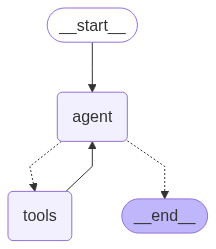

In [49]:
agent_executor = create_react_agent(llm, tools, state_modifier=system_prompt_template)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

#### Questions

"Which cities have the most customers?"
"Which customers are located in London?"
"Who are the customers with most orders?"
"Which employee has processed the most orders?"
"Show me the sales performance of each employee (e.g., total order value)."
"What are the top products with most orders?"
"What is the average price of products by category?"
"Who are the top suppliers of Teatime Chocolate Biscuits with lowest unit price?"
"What is the average dollar value (calculated as unit price * quantity) of an order?"
"What are the minimum and maximum order dates?"
"List the products supplied by suppliers located in the USA"
"Which customers ordered products from the 'Seafood' category?"

In [ ]:
question = "Which customers ordered products from the 'Seafood' category?"
query = {"messages": [HumanMessage(question)]}

# for step in agent_executor.stream(query, stream_mode="updates"):
#     print(step)

# for step in agent_executor.stream(query, stream_mode="updates"):
#     if "agent" in step:
#         if "messages" in step["agent"]:
#             for message in step["agent"]["messages"]:
#                 if hasattr(message, "content") and message.content:
#                     print(f"Agent: {message.content}")
#                 elif hasattr(message, "tool_calls") and message.tool_calls:
#                     print("Agent is calling tools:")
#                     for tool_call in message.tool_calls:
#                         print(f"  Tool Name: {tool_call['name']}")
#                         print(f"  Tool Arguments: {tool_call['args']}")
#     elif "tools" in step:
#         if "messages" in step["tools"]:
#             for message in step["tools"]["messages"]:
#                 if hasattr(message, "content"):
#                     print(f"Tool Result ({message.name}): {message.content}")


for step in agent_executor.stream(query, stream_mode="updates"):
    if "agent" in step and "messages" in step["agent"]:
        for message in step["agent"]["messages"]:
            # Call pretty_print on the AgentMessage object
            message.pretty_print()  
    elif "tools" in step and "messages" in step["tools"]:
        for message in step["tools"]["messages"]:
            # Call pretty_print on the ToolMessage object
            message.pretty_print()  

================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_Unv4B5YpuFHPRXmSaDIkIw2C)
 Call ID: call_Unv4B5YpuFHPRXmSaDIkIw2C
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Categories, CustomerCustomerDemo, CustomerDemographics, Customers, EmployeeTerritories, Employees, Order Details, Orders, Products, Regions, Shippers, Suppliers, Territories
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_ixGiqWhbpLo1avvzvReAGOgY)
 Call ID: call_ixGiqWhbpLo1avvzvReAGOgY
  Args:
    table_names: Categories, Customers, Products, Orders, Order Details
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Categories" (
	"CategoryID" INTEGER, 
	"CategoryName" TEXT, 
	"Description" TEXT, 
	"Picture" BLOB, 
	PRIMARY KEY ("CategoryID")
)

/*
3 rows from 